In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import re
import string

### Criando a função para gerar a matrix de confusão

In [51]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### Importing the DataSet

In [52]:


df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")


In [53]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [54]:
df_true.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


### Inserting a column "class" as target feature

In [55]:
df_fake["class"] = 0
df_true["class"] = 1

In [56]:


df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

In [57]:
# Removing last 10 rows for manual testing
df_fake_manual_testing = df_fake.tail(10)
for i in range(23480,23470,-1):
    df_fake.drop([i], axis = 0, inplace = True)
    
    
df_true_manual_testing = df_true.tail(10)
for i in range(21416,21406,-1):
    df_true.drop([i], axis = 0, inplace = True)

In [58]:


df_fake.shape, df_true.shape



((23471, 5), (21407, 5))

In [59]:
df_fake_manual_testing["class"] = 0
df_true_manual_testing["class"] = 1

/tmp/ipykernel_568241/860779283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fake_manual_testing["class"] = 0
/tmp/ipykernel_568241/860779283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_manual_testing["class"] = 1


In [60]:
df_fake_manual_testing.head(10)

,title,text,subject,date,class
23471,Seven Iranians freed in the prisoner swap have...,"21st Century Wire says This week, the historic...",Middle-east,"January 20, 2016",0
23472,#Hashtag Hell & The Fake Left,By Dady Chery and Gilbert MercierAll writers ...,Middle-east,"January 19, 2016",0
23473,Astroturfing: Journalist Reveals Brainwashing ...,Vic Bishop Waking TimesOur reality is carefull...,Middle-east,"January 19, 2016",0
23474,The New American Century: An Era of Fraud,Paul Craig RobertsIn the last years of the 20t...,Middle-east,"January 19, 2016",0
23475,Hillary Clinton: ‘Israel First’ (and no peace ...,Robert Fantina CounterpunchAlthough the United...,Middle-east,"January 18, 2016",0
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [61]:
df_true_manual_testing.head(10)

,title,text,subject,date,class
21407,"Mata Pires, owner of embattled Brazil builder ...","SAO PAULO (Reuters) - Cesar Mata Pires, the ow...",worldnews,"August 22, 2017",1
21408,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
21409,"U.S., North Korea clash at U.N. arms forum on ...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
21410,Headless torso could belong to submarine journ...,COPENHAGEN (Reuters) - Danish police said on T...,worldnews,"August 22, 2017",1
21411,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,"August 21, 2017",1
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


### Merging True and Fake Dataframes

In [62]:
df_manual_testing = pd.concat([df_fake_manual_testing,df_true_manual_testing], axis = 0)
df_manual_testing.to_csv("manual_testing.csv")

In [63]:


df_merge = pd.concat([df_fake, df_true], axis =0 )
df_merge.head(10)



,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",0


In [64]:
df_merge.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

### Removing columns which are not required

In [65]:
df = df_merge.drop(["title", "subject","date"], axis = 1)

In [66]:
df.isnull().sum()

text     0
class    0
dtype: int64

### Random Shuffling the dataframe

In [67]:
df = df.sample(frac = 1)

In [68]:
df.head()

,text,class
5152,WASHINGTON (Reuters) - Representative Adam Sch...,1
2443,"On the same day that bomb threats were made, m...",0
1930,Rep. Elijah E. Cummings is demanding answers a...,0
70,The following statements were posted to the ve...,1
16379,MADRID (Reuters) - Catalan leader Carles Puigd...,1


In [69]:


df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)



In [70]:
df.columns

Index(['text', 'class'], dtype='object')

In [71]:
df.head()

,text,class
0,WASHINGTON (Reuters) - Representative Adam Sch...,1
1,"On the same day that bomb threats were made, m...",0
2,Rep. Elijah E. Cummings is demanding answers a...,0
3,The following statements were posted to the ve...,1
4,MADRID (Reuters) - Catalan leader Carles Puigd...,1


### Function to process the texts

In [72]:


def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text



In [73]:
df["text"] = df["text"].apply(wordopt)

In [74]:
x = df["text"]
y = df["class"]

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.75)

### Convert text to vectors

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

### Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(solver="lbfgs")
LR.fit(xv_train,y_train)

LogisticRegression()

In [78]:
pred_lr=LR.predict(xv_test)
print(pred_lr)

[0 1 1 ... 0 0 1]


In [79]:
logic_regression_result = LR.score(xv_test, y_test)
print(logic_regression_result)

0.9793517335630886


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     17540
           1       0.98      0.98      0.98     16119

    accuracy                           0.98     33659
   macro avg       0.98      0.98      0.98     33659
weighted avg       0.98      0.98      0.98     33659



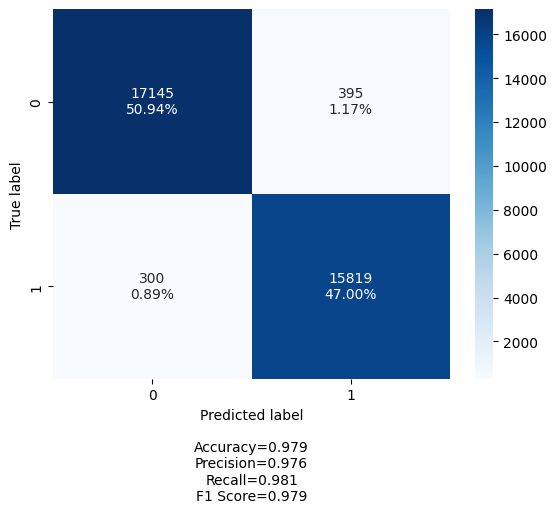

In [80]:
print(classification_report(y_test, pred_lr))
cm = confusion_matrix(y_test, pred_lr)
make_confusion_matrix(cf= cm)

### Decision Tree Classification

In [81]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(criterion='entropy')
DT.fit(xv_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [82]:
pred_dt = DT.predict(xv_test)

In [83]:
decision_tree_result = DT.score(xv_test, y_test)
print(decision_tree_result)

0.9932261802192579


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     17540
           1       0.99      0.99      0.99     16119

    accuracy                           0.99     33659
   macro avg       0.99      0.99      0.99     33659
weighted avg       0.99      0.99      0.99     33659



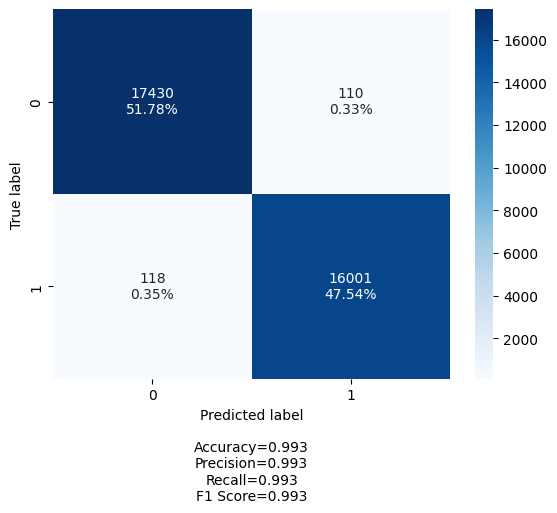

In [84]:
print(classification_report(y_test, pred_dt))
cm = confusion_matrix(y_test, pred_dt)
make_confusion_matrix(cf= cm)

### Multinomial Naive bayes

In [85]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(force_alpha=True, alpha=0.1)
clf.fit(xv_train, y_train)

MultinomialNB(alpha=0.1, force_alpha=True)

In [86]:
pred_clf = clf.predict(xv_test)

In [87]:
multinominal_naive_result = clf.score(xv_test, y_test)
print(multinominal_naive_result)

0.9365102944234825


              precision    recall  f1-score   support

           0       0.93      0.94      0.94     17540
           1       0.94      0.93      0.93     16119

    accuracy                           0.94     33659
   macro avg       0.94      0.94      0.94     33659
weighted avg       0.94      0.94      0.94     33659



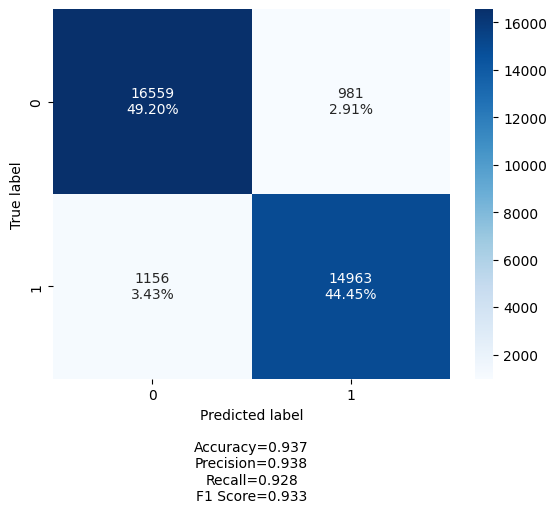

In [88]:
print(classification_report(y_test, pred_clf))
cm = confusion_matrix(y_test, pred_clf)
make_confusion_matrix(cf= cm)

### Support Vector Machine

In [89]:
from sklearn import svm
svm_test = svm.SVC(C=1,kernel='linear')
svm_test.fit(xv_train, y_train)

SVC(C=1, kernel='linear')

In [90]:
pred_svm = svm_test.predict(xv_test)

In [91]:
support_vector_machine_result = svm_test.score(xv_test, y_test)
print(support_vector_machine_result)

0.9883240737989839


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     17540
           1       0.99      0.99      0.99     16119

    accuracy                           0.99     33659
   macro avg       0.99      0.99      0.99     33659
weighted avg       0.99      0.99      0.99     33659



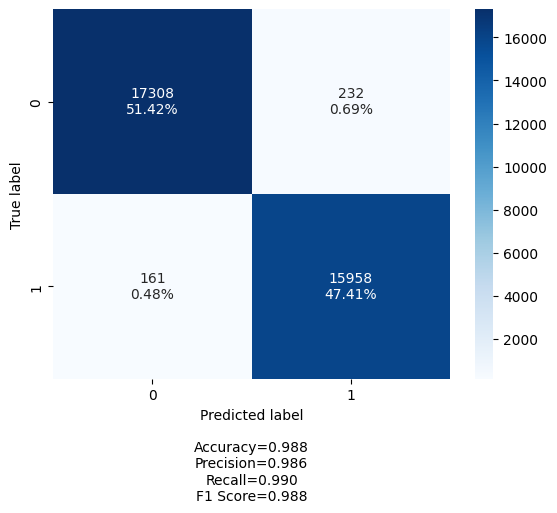

In [92]:
print(classification_report(y_test, pred_svm))
cm = confusion_matrix(y_test, pred_svm)
make_confusion_matrix(cf= cm)

### K-nearest_neighbor

In [93]:
from sklearn.neighbors import KNeighborsClassifier
neigh_test = KNeighborsClassifier(n_neighbors=1)
neigh_test.fit(xv_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [94]:
pred_neigh = neigh_test.predict(xv_test)

In [95]:
k_nearest_neighbor_result = neigh_test.score(xv_test, y_test)
print(k_nearest_neighbor_result)

0.7176980896639829


              precision    recall  f1-score   support

           0       0.66      0.96      0.78     17540
           1       0.92      0.45      0.60     16119

    accuracy                           0.72     33659
   macro avg       0.79      0.71      0.69     33659
weighted avg       0.78      0.72      0.70     33659



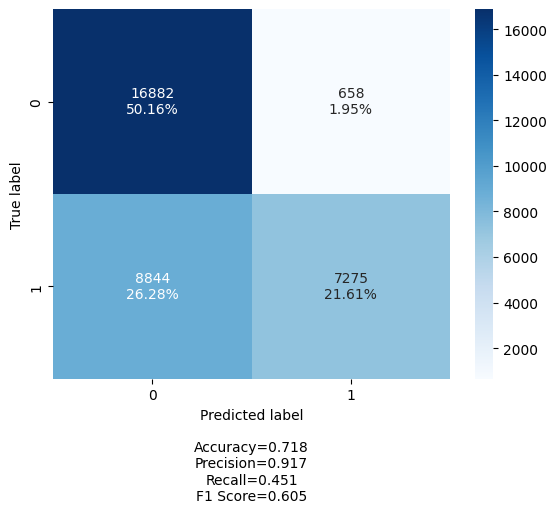

In [96]:
print(classification_report(y_test, pred_neigh))
cm = confusion_matrix(y_test, pred_neigh)
make_confusion_matrix(cf= cm)

### Results

Text(0.5, 0.98, 'Acurácia - 75% das observações - Melhores parâmetros')

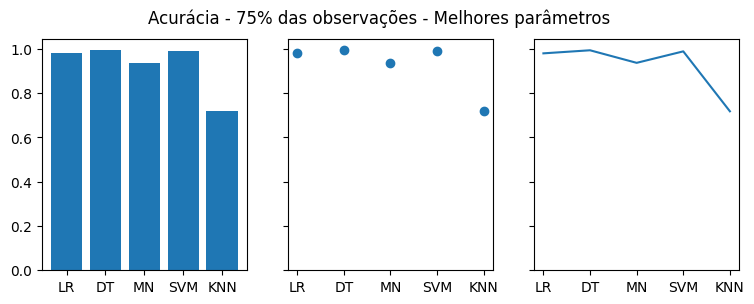

In [97]:
import matplotlib.pyplot as plt

data = {
    'LR': logic_regression_result,
    'DT': decision_tree_result,
    'MN': multinominal_naive_result,
    'SVM': support_vector_machine_result,
    'KNN': k_nearest_neighbor_result
}

names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 3, figsize=(9,3), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names,values)
axs[2].plot(names, values)
fig.suptitle('Acurácia - N = 33659 - Melhores parâmetros')


[[0.9793517335630886, 0.9932261802192579, 0.9365102944234825, 0.9883240737989839, 0.7176980896639829]]


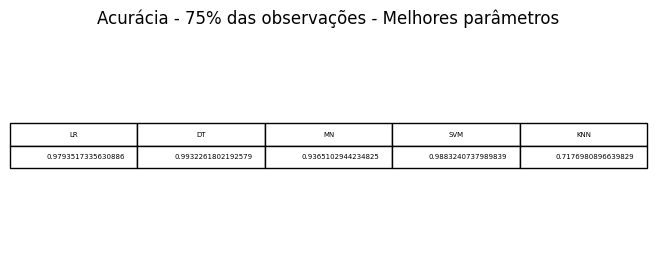

In [98]:
fig, axs =plt.subplots(2,1)
clust_data = [[
    logic_regression_result,
    decision_tree_result,
    multinominal_naive_result,
    support_vector_machine_result,
    k_nearest_neighbor_result
    ]]
print(clust_data)
collabel=('LR', 'DT', 'MN', 'SVM', 'KNN')
axs[0].axis('tight')
axs[0].axis('off')
axs[1].set_visible(False)
axs[0].set_title('Acurácia - N = 33659 - Melhores parâmetros', fontsize=12)
the_table = axs[0].table(cellText=clust_data,colLabels=collabel,loc='center')

plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
